# WORKSHOP 2

------------

**<u>GRUPO 4<u>**

Digital House

link git hub: https://github.com/grupo4dhds/grupo4_git.git

--------------

## CONTENIDO


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

In [3]:
def lista_featurend(X, label_i):
    for i in range(len(X.columns)):
        if list(X.columns)[i] == label_i:
            lista_featur_end = (list(X.columns)[i:])
    return lista_featur_end
        
def cambia_nombre_columnas(data, **kwarg):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
    for key in kwarg.keys():
        data.rename(kwarg[key], axis=1, inplace=True)
    return data

def cambia_orden_columnas(check_list, data, safe=1): # safe: es para conservar la primera columna con indice[0]
    label_list = list(data.columns)
    for i in range(len(check_list)):
        label_list.remove(check_list[i])
        label_list.insert(i+safe, check_list[i])
        data = data.reindex(label_list, axis=1)
        
def data_info(data, name='data'):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ['columna']
    df.columns.name = f'df de {name}'
    df.index.name = 'index'
    df['Nan'] = data.isna().sum().values
    df['dtype']  = data.dtypes.values
    df['count'] = data.count().values
    df['pct_nan'] = round(df['Nan']/data.shape[0]*100,2)
    df['count_unique'] = [len(data[elemento].value_counts()) for elemento in data.columns]
    return df


def visualizacion_dos_scatter(frame1, frame2, x, y_1, y_2):
    x1 = frame1[x]
    x2 = frame2[x]
    y_real = frame1[y_1]
    y_pred = frame2[y_2]
    plt.scatter(x1, y_real)
    plt.scatter(x2, y_pred) # muestra, entonces com
    plt.suptitle('y, y_pred');
    
    
    ax = plt.axes() #instancia de un objeto
    # tiene atributos y tiene métodos
    # los atributos .algo y los métodos son .algo()
    # 
    ax.set(xlabel = 'x', ylabel='price')
    #azules reales
    #naranjas predichos
    

    """
dame dos datasets, ya filtrados

# separame el eje x, de cualquier de los dos datasets
# armame una serie de cada valor real/predicho
""";
def variables_feature(frame):
    frame['sup_total_pow2'] = frame.surface_total_in_m2 * frame.surface_total_in_m2
    frame['sup_descubierta'] = frame.surface_total_in_m2 - frame.surface_covered_in_m2
    frame['sup_descubierta_pct'] = frame.sup_descubierta / frame.surface_total_in_m2 *100
    frame = frame.drop('sup_descubierta', axis=1)
    return frame

def analisis_nans(frame):
    df = data_info(frame)
    lista_not_na = list((df[df.Nan == 0].columna).values)
    lista_con_na = list((df[df.Nan != 0].columna).values)
    
    print ('ANALISIS DE NANS')
    print (frame[lista_con_na].isna().sum().to_string())
    #print ('La suma es {}'.format(3198+746))
    print ('Cantidad de elemento: {}'.format(frame[lista_con_na].shape[0]))
    print ('Interseccion entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().all(axis=1).sum()))
    print('Union entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().any(axis=1).sum()))

In [4]:
data = pd.read_csv('data_apartment_5_final.csv')
data.drop(list(data.columns)[0], axis=1, inplace=True)
lista_columnas_1 = list(data.columns)[:9]
lista_columnas_2 = lista_featurend(data,'above_mean')
print(lista_columnas_1)
print(lista_columnas_2)
data = data.loc[:,lista_columnas_1 + lista_columnas_2]

Dicto = {}

['property_type', 'place_name', 'state_name', 'price', 'currency', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'place_name_2']
['above_mean', 'above_median']


In [5]:
df = data_info(data)
df

df de data,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,15942,0.00,1
1,place_name,0,object,15942,0.00,113
2,state_name,0,object,15942,0.00,5
3,price,0,float64,15942,0.00,2671
4,currency,0,object,15942,0.00,1
5,surface_total_in_m2,3198,float64,12744,20.06,168
6,surface_covered_in_m2,746,float64,15196,4.68,191
7,price_usd_per_m2,0,float64,15942,0.00,6332
8,place_name_2,0,object,15942,0.00,51


In [6]:
lista_not_na = list((df[df.Nan == 0].columna).values)
lista_con_na = list((df[df.Nan != 0].columna).values)

In [7]:
print ('ANALISIS DE NANS')
print (data[lista_con_na].isna().sum().to_string())
print ('La suma es {}'.format(3198+746))
print ('Cantidad de elemento: {}'.format(data[lista_con_na].shape[0]))

print ('Interseccion entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().all(axis=1).sum()))
print('Union entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().any(axis=1).sum()))

print ('\nSe toma muestra de los valores y se los quita del dataset')

muestra = data[data[lista_con_na].isna().any(axis=1)]
df = data_info(muestra, 'surface_nan')
data = data.drop(muestra.index)

Dicto['data_cruda'] = data.to_dict(), data_info(data).to_dict()
Dicto['surface_nan'] = muestra.to_dict(), df.to_dict()

ANALISIS DE NANS
surface_total_in_m2      3198
surface_covered_in_m2     746
La suma es 3944
Cantidad de elemento: 15942
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 3944 elementos

Se toma muestra de los valores y se los quita del dataset


In [8]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,above_mean,above_median
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,55.0,1309.090909,Mataderos,0.0,1.0
1,apartment,Mataderos,Capital Federal,67000.0,USD,40.0,28.0,1675.000000,Mataderos,0.0,0.0
2,apartment,Mataderos,Capital Federal,90000.0,USD,52.0,48.0,1730.769231,Mataderos,0.0,1.0
3,apartment,Mataderos,Capital Federal,88000.0,USD,50.0,38.0,1760.000000,Mataderos,0.0,0.0
4,apartment,Mataderos,Capital Federal,93600.0,USD,51.0,46.0,1835.294118,Mataderos,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,77000.0,USD,40.0,40.0,1925.000000,otros,0.0,0.0
15938,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,77000.0,USD,40.0,40.0,1925.000000,otros,0.0,0.0
15939,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,75000.0,USD,40.0,40.0,1875.000000,otros,0.0,0.0
15940,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,140000.0,USD,80.0,80.0,1750.000000,otros,1.0,1.0


In [9]:
data = variables_feature(data)

dummy_place = pd.get_dummies(data['place_name_2'])
df = data_info(dummy_place)['columna']

place_name_2 = data.place_name_2
data = data.drop('place_name_2', axis=1)

Dicto['data'] = data_info(data).to_dict(), data.to_dict()
Dicto['dummy_place'] = df.to_dict(), dummy_place.to_dict()

In [10]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,above_mean,above_median,sup_total_pow2,sup_descubierta_pct
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,55.0,1309.090909,0.0,1.0,3025.0,0.000000
1,apartment,Mataderos,Capital Federal,67000.0,USD,40.0,28.0,1675.000000,0.0,0.0,1600.0,30.000000
2,apartment,Mataderos,Capital Federal,90000.0,USD,52.0,48.0,1730.769231,0.0,1.0,2704.0,7.692308
3,apartment,Mataderos,Capital Federal,88000.0,USD,50.0,38.0,1760.000000,0.0,0.0,2500.0,24.000000
4,apartment,Mataderos,Capital Federal,93600.0,USD,51.0,46.0,1835.294118,0.0,0.0,2601.0,9.803922
...,...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,77000.0,USD,40.0,40.0,1925.000000,0.0,0.0,1600.0,0.000000
15938,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,77000.0,USD,40.0,40.0,1925.000000,0.0,0.0,1600.0,0.000000
15939,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,75000.0,USD,40.0,40.0,1875.000000,0.0,0.0,1600.0,0.000000
15940,apartment,El Palomar,Bs.As. G.B.A. Zona Oeste,140000.0,USD,80.0,80.0,1750.000000,1.0,1.0,6400.0,0.000000


In [11]:
print (pd.Series(data.columns).to_string())

0             property_type
1                place_name
2                state_name
3                     price
4                  currency
5       surface_total_in_m2
6     surface_covered_in_m2
7          price_usd_per_m2
8                above_mean
9              above_median
10           sup_total_pow2
11      sup_descubierta_pct


In [12]:
# 1. Seleccion de la clase de modelo
from sklearn.linear_model import LinearRegression

# 2. Elegir los hiperparámetros del modelo
linreg = LinearRegression(normalize=True) # False: default but then change to True and see changes

#3. Preparar los datos en una matriz de features, y un vector target

features_1 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_mean']
features_2 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_median']

X = data[features_1]
X = pd.concat([X,dummy_place], axis=1)


y = data.price
y = y[y.index.intersection(X.index)]

#4. Separar los sets de entrenamiento y de testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

#5. Ajustar el modelo a los datos de entrenamiento
linreg.fit(Xtrain, ytrain)

#6. Predecir etiquetas para datos desconocidos
y_pred = linreg.predict(Xtest)

#7. Evaluar la perfomance del modelo

from sklearn import metrics

print ('MAE:', metrics.mean_absolute_error(ytest, y_pred))
print ('MSE:', metrics.mean_squared_error(ytest, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print ('R2:', metrics.r2_score(ytest, y_pred))

MAE: 26105.60954074071
MSE: 1266840578.3410313
RMSE: 35592.70400434661
R2: 0.828237097073263


In [13]:
#import statsmodels as sm # error
#help(LinearRegression)
#help(LinearRegression.predict)
#help(sm.fittedvalues) # no logro hacerlo funcionar proviene de la notebook de dani
"""
    VALORES CON valor=84, valor: cantidad de publicaciones minimas para conservar place_name
Normalize: False (no varía si se cambia a True)
MAE: 26388.597029743163
MSE: 1290767140.9256575
RMSE: 35927.247889668055
R2: 0.8201073191954292

    VALORES CON valor=63
    feature_1
MAE: 26105.609540740712
MSE: 1266840578.3410313
RMSE: 35592.70400434661
R2: 0.828237097073263
    VALORES CON valor=63
    feature_2
MAE: 26093.385049955825
MSE: 1266894552.180633
RMSE: 35593.462211207174
R2: 0.8282297791016645
    diferencia
f2-f1 (MAE) = -12
f2-f1 (MSE) = 53.974 (elegimos feature 1)
f2-f1 (RMSE) = 1
f2-f1 (R2) = -0,000008

(wrong!)    VALORES = 63 : otros
    feature_1
    select: surface_covered_in_m2
MAE: 25885.978562020075
MSE: 1286649928.941028
RMSE: 35869.90282870903
R2: 0.8255512724933425

""";

--------------------
**EVALUACION VISUAL DEL MODELO CON DATOS DE OTRA MUESTRA PERO QUE SEAN REPRESENTATIVOS DE ESTA**

In [14]:
data_aux = pd.DataFrame(Dicto['data'][1])

features_1
lista = []
for i in range(len(list(data_aux.columns))):
    booleano = False
    for j in range(len(features_1)):
        elemento = features_1[j] in list(data_aux.columns)[i]
        if elemento: 
            booleano = True            
    lista.append(booleano)
    
not_features_1 = []
for i in range(len(lista)):
    if lista[i] == False:
        not_features_1.append(list(data_aux.columns)[i])
        
data_aux = data_aux[not_features_1]
data_aux = data_aux.drop('above_median', axis=1)

data_aux.head(1)

,property_type,place_name,state_name,price,currency,surface_covered_in_m2,price_usd_per_m2
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,1309.090909


In [15]:
#########CREACION COLUMNA y_pred
data = data[features_1]
data = pd.concat([data,dummy_place], axis=1)
array_predict = linreg.predict(data)
data['y_pred'] = array_predict
data.head(1)

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,Barracas,...,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros,y_pred
0,55.0,3025.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,123285.839271


In [16]:
data = pd.concat([data_aux,data], axis=1)
data.head(1)


,property_type,place_name,state_name,price,currency,surface_covered_in_m2,price_usd_per_m2,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,...,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros,y_pred
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,1309.090909,55.0,3025.0,0.0,...,0,0,0,0,0,0,0,0,0,123285.839271


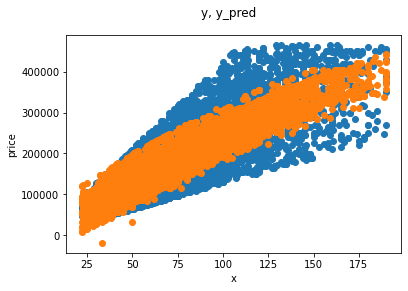

In [17]:
visualizacion_dos_scatter(data,data,'surface_total_in_m2', 'price','y_pred')

--------------------
**EXPLORACION DE LA MUESTRA**

In [18]:
serie_same = pd.Series(Dicto['dummy_place'][0])
serie_same;

In [19]:
muestra = pd.read_csv('muestra_currency_nan.csv')
muestra = muestra.drop(list(muestra.columns)[0], axis=1)
mask_1 = muestra.property_type == 'apartment'
mask_2 = muestra.place_name.isin(serie_same)

muestra = muestra[mask_1 & mask_2]

muestra = variables_feature(muestra)
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
75,apartment,Villa Devoto,Capital Federal,NaN,NaN,68.0,NaN,NaN,4624.0,NaN
...,...,...,...,...,...,...,...,...,...,...
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308
15535,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,NaN,70.0,NaN,NaN,NaN


In [20]:
display (data_info(muestra,'muestra'))
analisis_nans(muestra.loc[:,['surface_total_in_m2', 'surface_covered_in_m2','place_name']])
print ()
print ('Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"')

muestra = muestra.loc[muestra.sup_descubierta_pct.notna()]
muestra

df de muestra,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,1959,0.00,1
1,place_name,0,object,1959,0.00,46
2,state_name,0,object,1959,0.00,6
3,price,1959,float64,0,100.00,0
4,currency,1959,float64,0,100.00,0
5,surface_total_in_m2,147,float64,1812,7.50,210
6,surface_covered_in_m2,394,float64,1565,20.11,181
7,price_usd_per_m2,1959,float64,0,100.00,0
8,sup_total_pow2,147,float64,1812,7.50,210


ANALISIS DE NANS
surface_total_in_m2      147
surface_covered_in_m2    394
Cantidad de elemento: 1959
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 541 elementos

Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"


,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308


In [21]:
data_check = pd.read_csv('data_apartment_4_statistic.csv')
data_check = data_check.rename({'Unnamed: 0':'place_name'}, axis=1)
data_check.set_index('place_name', inplace=True)

apartment_mean = data_check['apartment_mean_surface_total_in_m2'].dropna()
lista_place_name = apartment_mean.index
lista_apartment_mean = apartment_mean.values

for i, elemento in enumerate(lista_place_name):
    mascara_iter_1 = muestra['property_type'] == 'apartment'
    #display(np.array((muestra.loc[mascara_iter_1 & (muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)) # columna dummy
    muestra.loc[mascara_iter_1 & (muestra.place_name == elemento), 'above_mean'] = np.array((muestra.loc[mascara_iter_1 & (muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)
    
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000,0.0
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265,1.0
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000,1.0
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132,1.0
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308,1.0


In [22]:
##dummy de la muestra, reacondicionamiento
dummy_place_sample = pd.get_dummies(muestra.place_name)

lista_dummy_original = serie_same.values
lista_dummy_muestra = dummy_place_sample.columns

difference_1 = set(lista_dummy_original).difference(set(lista_dummy_muestra))
difference_2 = set(lista_dummy_muestra).difference(set(lista_dummy_original))
list_difference = list(difference_1.union(difference_2))
print(list_difference)#https://www.delftstack.com/es/howto/python/difference-between-two-lists-python/

dummy_place_sample.loc[:,difference_1] = 0
dummy_place_sample.columns;

['San Justo', 'Beccar', 'otros', 'Villa Bosch', 'Adrogué', 'Villa Luzuriaga', 'Wilde', 'Barrio Los Alisos']


In [23]:
serie_same;

In [24]:
#X = muestra[features_1]
X = pd.concat([muestra[features_1], dummy_place_sample], axis=1)
X


,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Balvanera,Banfield,Barracas,Barrio Norte,...,Villa Devoto,Villa Pueyrredón,San Justo,Beccar,otros,Villa Bosch,Adrogué,Villa Luzuriaga,Wilde,Barrio Los Alisos
35,55.0,3025.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,147.0,21609.0,8.163265,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,76.0,5776.0,0.000000,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,120.0,14400.0,0.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,120.0,14400.0,0.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15529,100.0,10000.0,6.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15530,100.0,10000.0,6.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15531,53.0,2809.0,16.981132,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15533,52.0,2704.0,7.692308,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
muestra['y_pred'] = linreg.predict(X)
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct,above_mean,y_pred
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000,0.0,107609.183333
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265,1.0,306170.902715
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000,1.0,196979.660036
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0,252973.566415
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0,252973.566415
...,...,...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0,221370.173737
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0,221370.173737
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132,1.0,101326.702128
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308,1.0,105345.294830


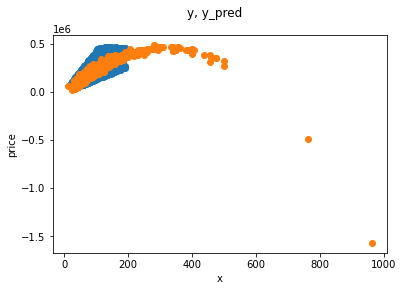

In [26]:
visualizacion_dos_scatter(data,muestra, x='surface_total_in_m2', y_1='price', y_2='y_pred')
# x: surface_total_in_m2
# puntos azules: valores reales de departamentos
# puntos naranjas: valores predicho sobre una muestra sin valores reales

    Conclusion:
        
        - El modelo predice mal para valores grandes de departamentos.
        - Se debe diferenciar por place_name para identificar los barrios en los que el modelo responde al patrón de precios

------------
**COMPROBACION VISUAL DEL RANGO DE APLICACION DEL MODELO**

In [27]:
dataview_1 = data[['property_type','surface_total_in_m2']]
dataview_1['place_name'] = place_name_2
dataview_1['price'] = data.price

dataview_1['id'] = 1

dataview_1

,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.0,1
1,apartment,40.0,Mataderos,67000.0,1
2,apartment,52.0,Mataderos,90000.0,1
3,apartment,50.0,Mataderos,88000.0,1
4,apartment,51.0,Mataderos,93600.0,1
...,...,...,...,...,...
15937,apartment,40.0,otros,77000.0,1
15938,apartment,40.0,otros,77000.0,1
15939,apartment,40.0,otros,75000.0,1
15940,apartment,80.0,otros,140000.0,1


In [28]:
dataview_2 = muestra[['property_type', 'surface_total_in_m2', 'place_name', 'y_pred']]

place_missing = set(place_name_2).difference(set(muestra.place_name)) # eliminar de la muestra original

dataview_2['id'] = 2

dataview_2

,property_type,surface_total_in_m2,place_name,y_pred,id
35,apartment,55.0,La Plata,107609.183333,2
46,apartment,147.0,Recoleta,306170.902715,2
61,apartment,76.0,Balvanera,196979.660036,2
74,apartment,120.0,La Plata,252973.566415,2
83,apartment,120.0,La Plata,252973.566415,2
...,...,...,...,...,...
15529,apartment,100.0,Castelar,221370.173737,2
15530,apartment,100.0,Castelar,221370.173737,2
15531,apartment,53.0,Castelar,101326.702128,2
15533,apartment,52.0,Castelar,105345.294830,2


In [29]:
dataview_1 = dataview_1.drop(dataview_1[dataview_1.place_name.isin(list(place_missing))].index)
#
print ('Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.')
#
dataview_1

Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.


,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.000000,1
1,apartment,40.0,Mataderos,67000.000000,1
2,apartment,52.0,Mataderos,90000.000000,1
3,apartment,50.0,Mataderos,88000.000000,1
4,apartment,51.0,Mataderos,93600.000000,1
...,...,...,...,...,...
15882,apartment,75.0,Güemes,168000.000000,1
15883,apartment,75.0,Güemes,155546.714375,1
15884,apartment,61.0,Güemes,132000.000000,1
15885,apartment,61.0,Güemes,123511.349226,1


In [30]:
dataview_2.rename({'y_pred': 'price'}, axis=1, inplace=True)
dataview_1 = dataview_1.append(dataview_2)

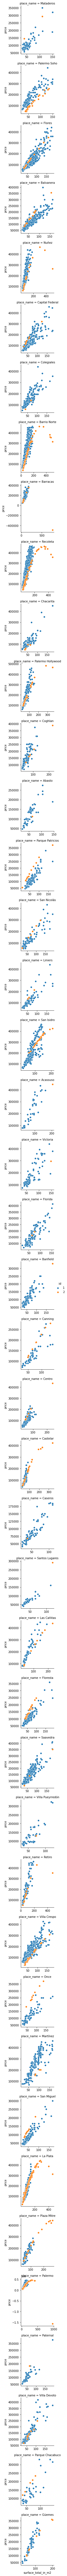

In [33]:
g = sns.FacetGrid(dataview_1, row = 'place_name', hue='id', sharex=False, sharey=False)
g.map(sns.scatterplot, 'surface_total_in_m2', 'price')
g.add_legend()
